In [1]:
# put this in it's own codeblock because it'll keep 
# running otherwise and eventually move to the root dir lol
%cd ../..

/Users/angus/code/jupyter/notebooks/20240907, vg


/Users/angus/code/jupyter/env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from lib.service.database import DatabaseService
from lib.defaults import INSTANCE_CFG

db = DatabaseService.create(INSTANCE_CFG[3].database, 1)
await db.wait_till_running()

dbname=gnaf_db_3 port=5431 user=postgres host=localhost password=throwAwayPassword3


<Axes: >

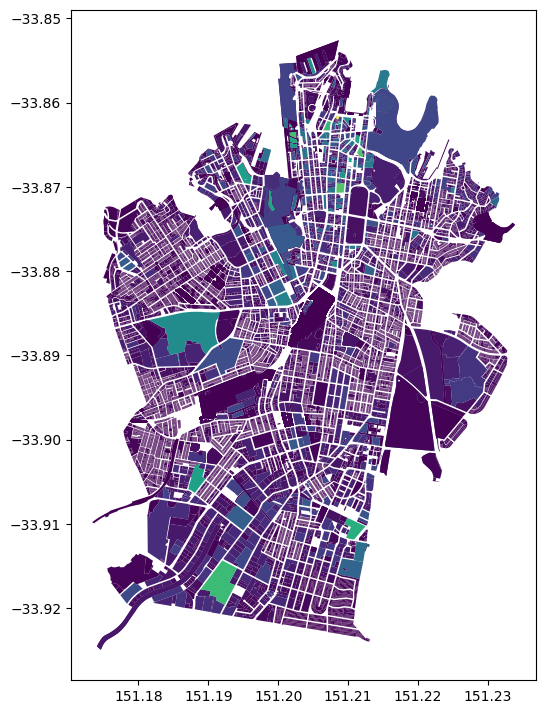

In [12]:
import geopandas as gpd

query = """
select property_id, lv.land_value as lv, pgeo.geometry as g
  from abs.lga_2024 lga
  left join nsw_lrs.property_geometry pgeo ON ST_Intersects(pgeo.geometry, lga.geometry)
  left join (
     SELECT DISTINCT ON (property_id) *
       FROM nsw_vg.land_valuation lv
       ORDER BY property_id, effective_date DESC
     ) lv USING (property_id)
  where lga_name ILIKE 'sydney'
    and lv.land_value IS NOT NULL;
"""

gpd\
  .read_postgis(query, db.engine(), geom_col='g')\
  .plot(column='lv', figsize=(6, 12))

<Axes: >

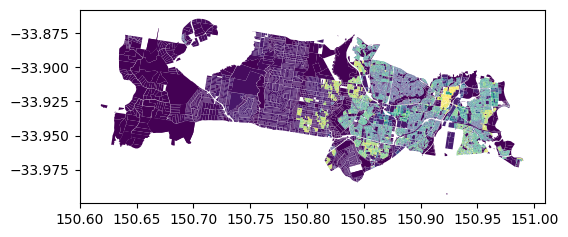

In [46]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

query = """
with properties as (
  select property_id, pgeo.geometry as g
    from abs.lga_2024 lga
    left join nsw_lrs.property_geometry pgeo ON ST_Intersects(pgeo.geometry, lga.geometry)
   where lga_name ILIKE 'liverpool'
     and (ST_Area(ST_Intersection(pgeo.geometry, lga.geometry)) / ST_Area(pgeo.geometry)) > 0.5
), lv_sqm as (
  select property_id, 
         (lv.land_value / ST_Area(p.g::geography)) as lv,
         p.g as g
    from properties p
    left join (
       SELECT DISTINCT ON (property_id) *
         FROM nsw_vg.land_valuation lv
         ORDER BY property_id, effective_date DESC
       ) lv USING (property_id)
    where lv.land_value IS NOT NULL)
select *, RANK() OVER (ORDER BY lv) AS rank
  from lv_sqm
"""

gdf = gpd.read_postgis(query, db.engine(), geom_col='g')
gdf.plot(
    column='rank',
    figsize=(6, 12),
    cmap="viridis",
)